# Nama Dataset: Brain Tumor MRI Dataset
**Sumber**: [Kaggle - Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset)

## Penjelasan Dataset:
Dataset ini berisi gambar MRI otak yang diklasifikasikan untuk mendeteksi adanya tumor otak dan sudah dipisahkan dalam beberapa kategori berdasarkan kondisi pasien.

## Struktur Dataset:
1. **Training** → Data untuk melatih model
2. **Testing** → Data untuk menguji model

Setiap folder berisi subfolder berdasarkan kategori.

## Jumlah Kelas:
1. **glioma_tumor** → Tumor berasal dari jaringan glial otak.
2. **meningioma_tumor** → Tumor dari membran sekitar otak (meninges).
3. **pituitary_tumor** → Tumor di kelenjar pituitari.
4. **no_tumor** → Tidak ada tumor (MRI normal).

**IMPORT LIBRARY**

In [ ]:
import os
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

**DOWNLOAD DATASET**

In [ ]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


**DATA LOADING**

Menginisialisasi direktori dataset, ukuran gambar sesuai spesifikasi MobileNetV2, ukuran batch untuk training, dan jumlah label kelas.

In [ ]:
train_dir = os.path.join(path, 'Training')
test_dir = os.path.join(path, 'Testing')

img_size = (224, 224)
batch_size = 32
num_classes = 4

**DATA AUGMENTATION**

Melakukan augmentasi pada data training seperti rotasi, zoom, shifting, shear, dan flip horizontal, serta merescaling pixel. Data testing hanya dilakukan rescaling, dan kedua data dimuat dengan ukuran 224x224 piksel dan mode kategorikal.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


**BUILD TRANSFER LEARNING MODEL + FINE TUNE**

Membangun model transfer learning dengan MobileNetV2, melakukan fine-tuning pada 30 layer terakhir, menambahkan custom classifier, dan meng-compile model menggunakan RMSprop serta fungsi loss categorical crossentropy.

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


**CALLBACKS**

Mengatur EarlyStopping untuk menghentikan pelatihan jika val_loss tidak membaik dalam 5 epoch, dan ReduceLROnPlateau untuk mengurangi learning rate saat performa model tidak meningkat dalam 3 epoch.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, verbose=1)

**TRAINING**

Model dilatih dengan data training dan divalidasi menggunakan data testing hingga 20 epoch, sambil mengaplikasikan callback untuk menghentikan training lebih awal atau menyesuaikan learning rate.

In [ ]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 154s 749ms/step - accuracy: 0.7837 - loss: 0.5638 - val_accuracy: 0.5881 - val_loss: 1.4030 - learning_rate: 1.0000e-04
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 517ms/step - accuracy: 0.9139 - loss: 0.2279 - val_accuracy: 0.7658 - val_loss: 0.7986 - learning_rate: 1.0000e-04
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 91s 508ms/step - accuracy: 0.9342 - loss: 0.1755 - val_accuracy: 0.7117 - val_loss: 0.9928 - learning_rate: 1.0000e-04
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 142s 511ms/step - accuracy: 0.9610 - loss: 0.1124 - val_accuracy: 0.7948 - val_loss: 0.7470 - learning_rate: 1.0000e-04
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 527ms/step - accuracy: 0.9614 - loss: 0.1099 - val_accuracy: 0.8795 - val_loss: 0.3906 - learning_rate: 1.0000e-04
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 531ms/step - accuracy: 0.9648 - loss: 0.0952 - val_accuracy: 0.9352 - val_loss: 0.2098 - learning_rate: 1.0000e-04
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 92s 

**EVALUASI**

Model menghasilkan prediksi pada data testing, kemudian hasilnya dievaluasi dengan classification report untuk menilai akurasi tiap kategori.

In [ ]:
# Prediksi
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Classification Report
print("Classification Report:\n", classification_report(test_generator.classes, y_pred, target_names=list(test_generator.class_indices.keys())))

41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step
Classification Report:
               precision    recall  f1-score   support

      glioma       0.97      0.95      0.96       300
  meningioma       0.95      0.96      0.95       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.97      0.99      0.98       300

    accuracy                           0.98      1311
   macro avg       0.97      0.97      0.97      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
from sklearn.metrics import accuracy_score

# Hitung accuracy score
acc = accuracy_score(test_generator.classes, y_pred)

print(f"Accuracy Score: {acc:.4f}")

Accuracy Score: 0.9764


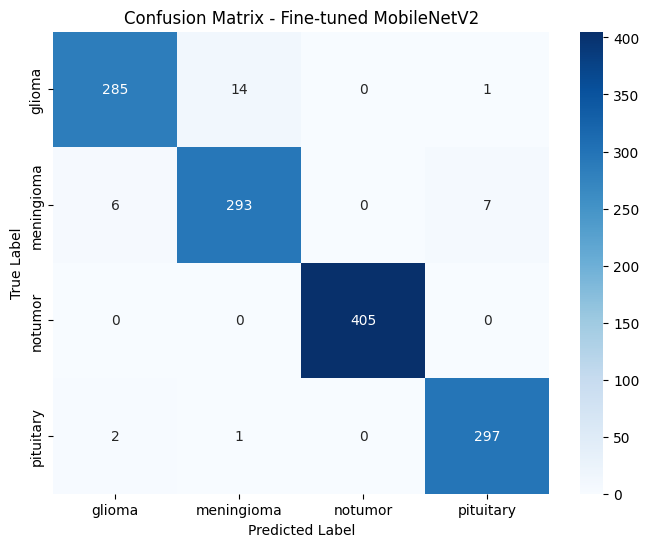

In [ ]:
# Confusion Matrix
cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(test_generator.class_indices.keys()),
            yticklabels=list(test_generator.class_indices.keys()))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Fine-tuned MobileNetV2')
plt.show()

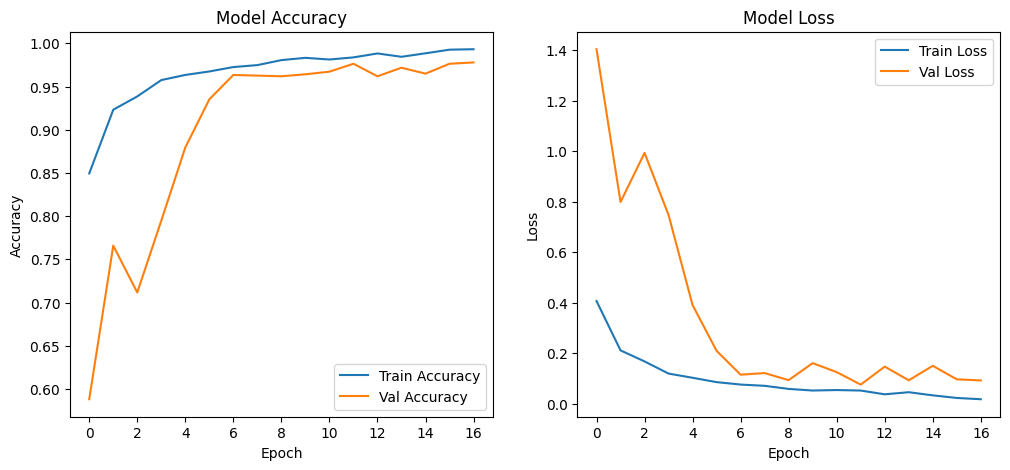

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

**TESTING MODEL DENGAN CARA UPLOAD GAMBAR**

Saving normal_brain.jpeg to normal_brain.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


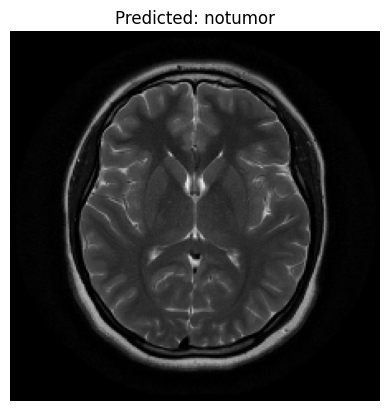

Model Predicts: notumor


In [ ]:
from tensorflow.keras.preprocessing import image
from google.colab import files

# Upload gambar
uploaded = files.upload()

for img_name in uploaded.keys():
    img_path = img_name
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    # Prediksi
    pred = model.predict(img_array)
    class_idx = np.argmax(pred)
    class_label = list(test_generator.class_indices.keys())[class_idx]

    # Output prediksi
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {class_label}")
    plt.show()

    print(f"Model Predicts: {class_label}")


**TESTING MODEL MENGGUNAKAN 6 GAMBAR ACAK**

Total sample images: 8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


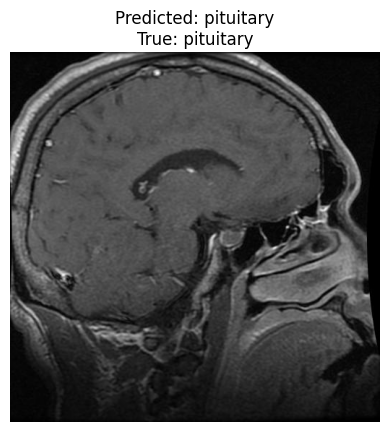

Predicted: pituitary | True: pituitary
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


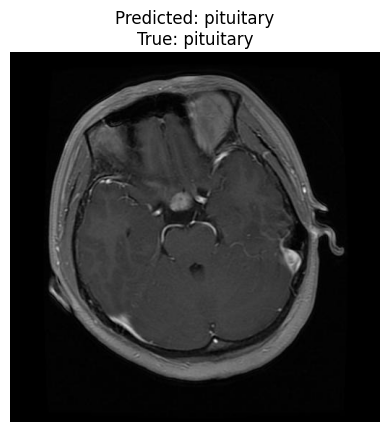

Predicted: pituitary | True: pituitary
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


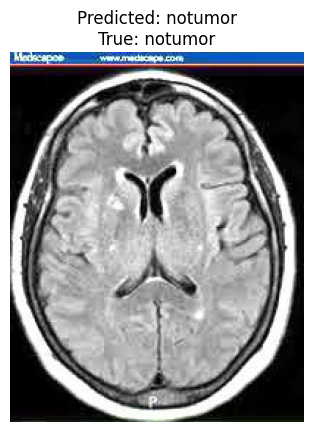

Predicted: notumor | True: notumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


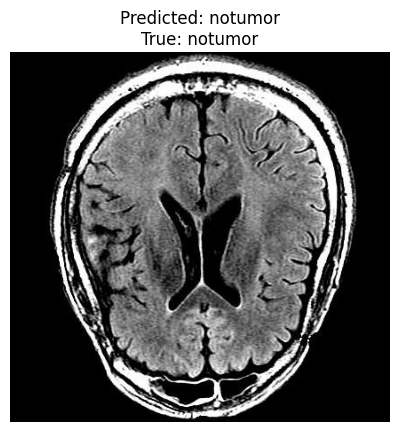

Predicted: notumor | True: notumor
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


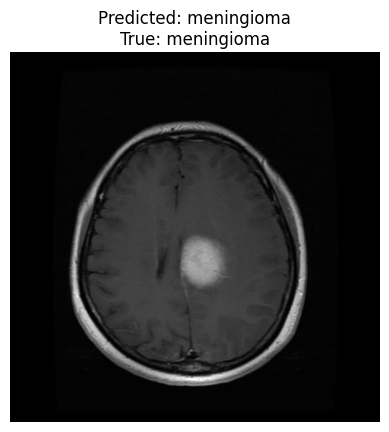

Predicted: meningioma | True: meningioma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


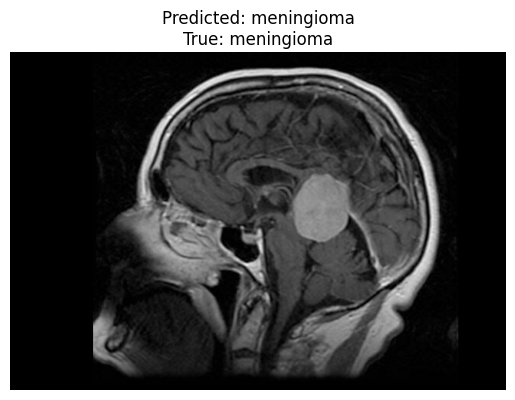

Predicted: meningioma | True: meningioma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


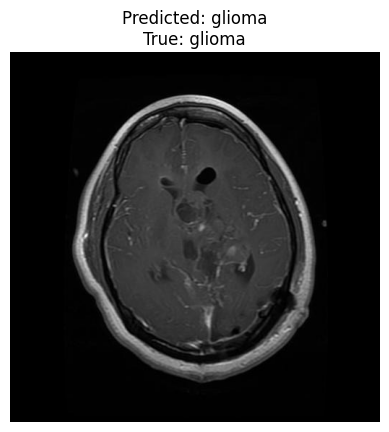

Predicted: glioma | True: glioma
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


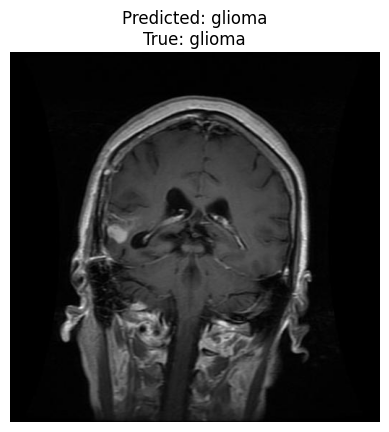

Predicted: glioma | True: glioma


In [ ]:
import random
import os
from tensorflow.keras.preprocessing import image

# Path testing dataset
test_path = os.path.join(path, 'Testing')

# Pilih random 6 gambar dari dataset Testing
sample_images = []
sample_labels = []

for label_folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, label_folder)
    if os.path.isdir(folder_path):
        images = os.listdir(folder_path)
        if len(images) >= 2:
            selected = random.sample(images, 2)
        else:
            selected = images
        for img_name in selected:
            sample_images.append(os.path.join(folder_path, img_name))
            sample_labels.append(label_folder)

print(f"Total sample images: {len(sample_images)}")

for img_path, true_label in zip(sample_images, sample_labels):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    pred = model.predict(img_array)
    pred_idx = np.argmax(pred)
    pred_label = list(test_generator.class_indices.keys())[pred_idx]

    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"Predicted: {pred_label}\nTrue: {true_label}")
    plt.show()

    print(f"Predicted: {pred_label} | True: {true_label}")